### Import Libraries

In [ ]:
%matplotlib inline
# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# SK-learn libraries for learning.
from sklearn.linear_model import LogisticRegression
import sklearn
# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *
import nltk
from sklearn.model_selection import train_test_split
import datetime
import xgboost as xgb
import warnings

### Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Ingest data
# Download data (or figure out how to get this)
# Link to file: https://www.kaggle.com/c/random-acts-of-pizza/data?select=train.json
# Link to file: https://www.kaggle.com/c/random-acts-of-pizza/data?select=test.json
filename_train = '/content/drive/My Drive/Colab Notebooks/train.json'
filename_test = '/content/drive/My Drive/Colab Notebooks/test.json'

# Load raw data
with open(filename_train) as file:
    rawDataTrain = json.load(file)
with open(filename_test) as file:
    rawDataTest = json.load(file)

# Load into pandas
test_cols = list(rawDataTest[0].keys())
featureNames = test_cols + ['requester_received_pizza']
DataRawDf = pd.DataFrame(columns=featureNames)
for featureNum in np.arange(len(featureNames)):
    DataRawDf[featureNames[featureNum]] = [rawDataTrain[postNum][featureNames[featureNum]] for postNum in np.arange(len(rawDataTrain))]

# Binarize the target variable and the giver_username field
DataRawDf['requester_received_pizza'] = DataRawDf['requester_received_pizza'].astype(np.int64) 
DataRawDf['giver_username_if_known'] = DataRawDf['giver_username_if_known'].apply(lambda x: 1 if x != "N/A" else 0)

# Kaggle test data
TestDataDf = pd.DataFrame(columns=test_cols)
for featureNum in np.arange(len(test_cols)):
    TestDataDf[featureNames[featureNum]] = [rawDataTest[postNum][featureNames[featureNum]] for postNum in np.arange(len(rawDataTest))]

# Binarize the target variable and the giver_username field
TestDataDf['giver_username_if_known'] = TestDataDf['giver_username_if_known'].apply(lambda x: 1 if x != "N/A" else 0)

### Split Data Into Train and Validation Sets

In [ ]:
# Split the data
X_train, X_validate, y_train, y_validate = train_test_split(DataRawDf, DataRawDf['requester_received_pizza'], random_state=12345)
X_test = TestDataDf

## **Exploratory Data Analysis**

### **Correlation Matrix Plots**

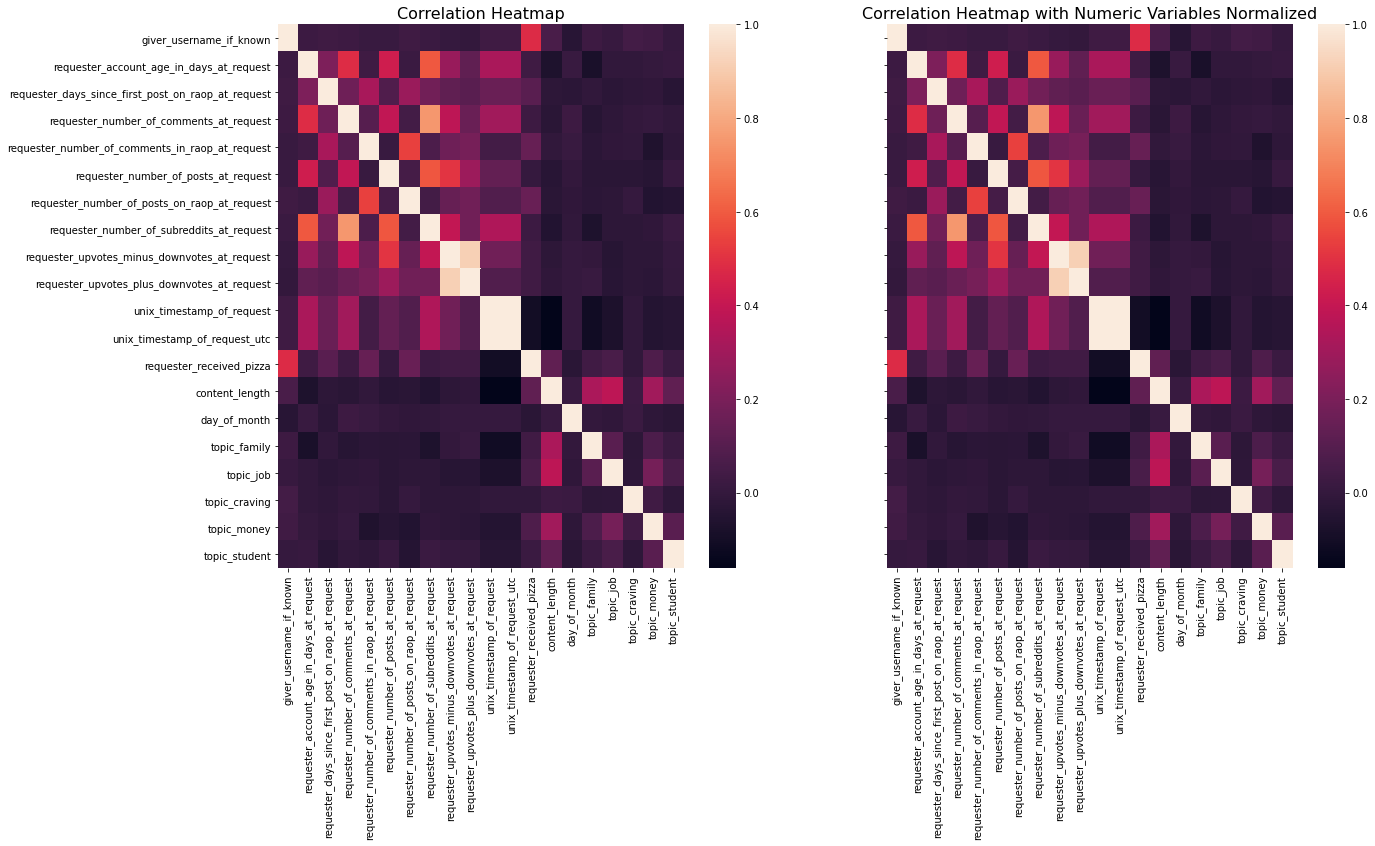

In [ ]:
# Extract numeric features
def get_numeric_dataframes(df):
    numeric_df = df.select_dtypes(include=['int64', 'float64', 'bool'])
    normalized_df = (numeric_df - numeric_df.min()) / (numeric_df.max() - numeric_df.min())
    return numeric_df, normalized_df
numeric_train_df, normalized_numeric_train_df = get_numeric_dataframes(X_train)
numeric_validate_df, normalized_numeric_validate_df = get_numeric_dataframes(X_validate)
numeric_test_df, normalized_numeric_test_df = get_numeric_dataframes(X_test)
corrmat = numeric_train_df.corr()
corrmat_norm = normalized_numeric_train_df.corr()
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(20,10))
sns.heatmap(corrmat, ax=ax[0])
sns.heatmap(corrmat_norm, ax=ax[1])

ax[0].set_title('Correlation Heatmap', fontsize=16)
ax[1].set_title('Correlation Heatmap with Numeric Variables Normalized', fontsize=16)

plt.show()

### **Distributions Of Each Feature**

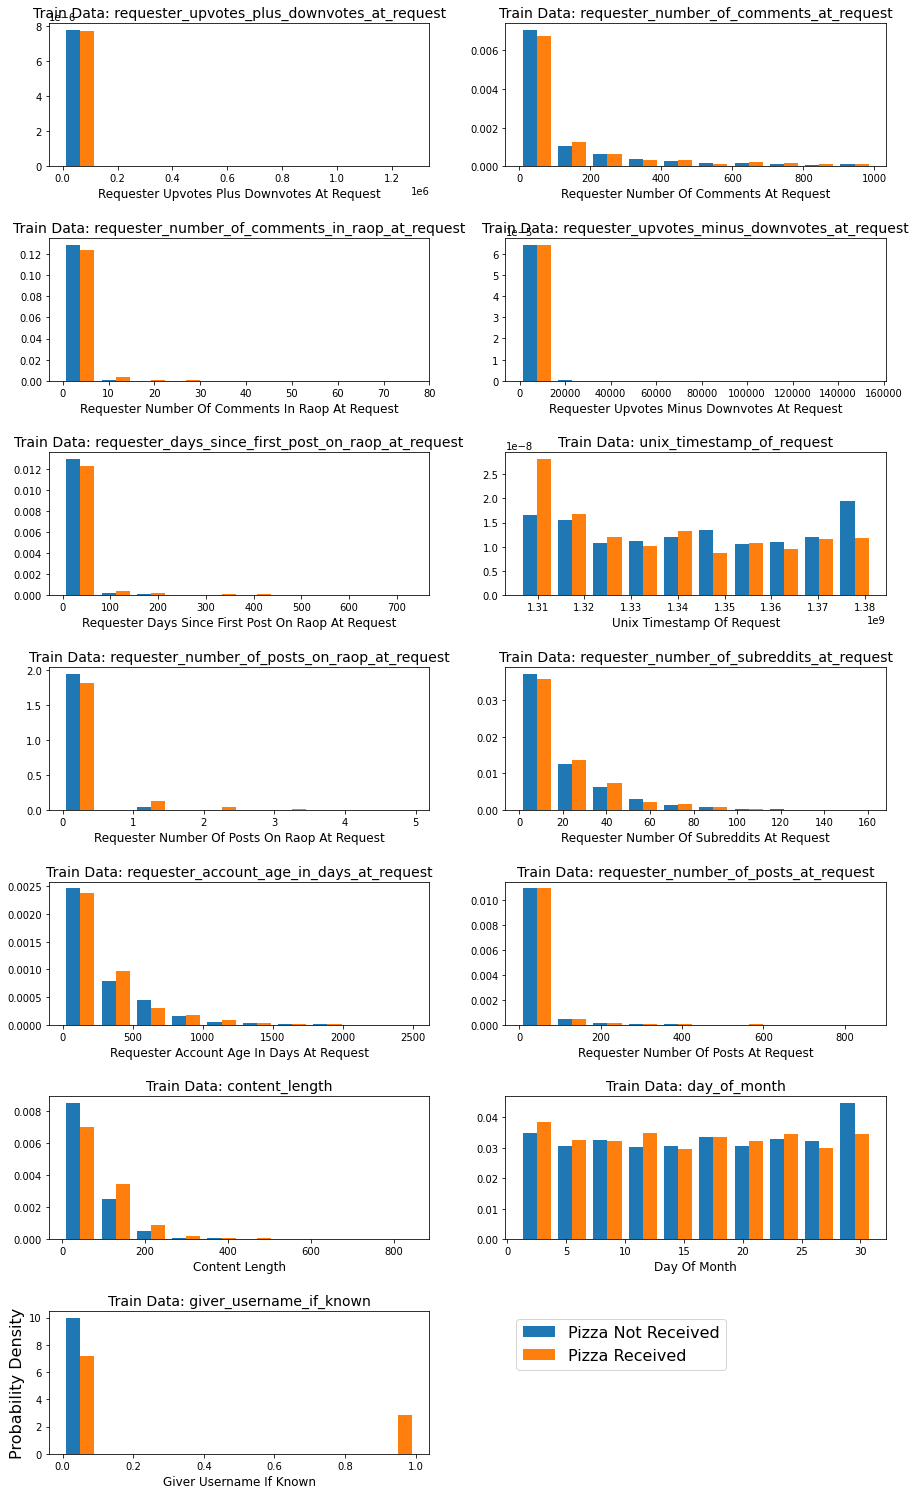

In [ ]:
from string import capwords

numericFeatures = ['requester_upvotes_plus_downvotes_at_request',
                   'requester_number_of_comments_at_request',
                   'requester_number_of_comments_in_raop_at_request',
                   'requester_upvotes_minus_downvotes_at_request',
                   'requester_days_since_first_post_on_raop_at_request',
                   'unix_timestamp_of_request',
                   'requester_number_of_posts_on_raop_at_request',
                   'requester_number_of_subreddits_at_request',
                   'requester_account_age_in_days_at_request',
                   'requester_number_of_posts_at_request'
                  ]

engineeredFeatures = ['content_length',
                      'day_of_month',
                      'giver_username_if_known'
                     ]

featuresToPlot = numericFeatures + engineeredFeatures

# plot histograms
figH = plt.figure(figsize=(15,50))

for featureNum in np.arange(len(featuresToPlot)):
    featureStr = featuresToPlot[featureNum]

    axH = figH.add_subplot(len(featuresToPlot), 2, featureNum+1)

    plt.hist([X_train.loc[X_train[featureStr].index[X_train['requester_received_pizza'] == 0], featureStr], 
              X_train.loc[X_train[featureStr].index[X_train['requester_received_pizza'] == 1], featureStr]
             ]
             , density=True)
    plt.title(' '.join(['Train Data:', featureStr]), fontsize=14)
    plt.xlabel(capwords(featureStr.replace('_', ' ')), fontsize=12)
    
    # legend
    if featureNum == len(featuresToPlot)-1:
        plt.legend(('Pizza Not Received', 'Pizza Received'), bbox_to_anchor=(.8, 0, 1, 1), fontsize=16)
        plt.ylabel('Probability Density', fontsize=16)
    
figH.subplots_adjust(hspace=0.5)


**Notable observations from histograms:**
* Maybe some outliers in number of upvotes/downvotes features
* unix_timestamp_of_request at early dates seems to have many more post with pizza received than not received
* content_length (i.e. how many words are in a post) seems to show that longer posts tend to receive pizzas
* day_of_month shows that over the last few days of the month less posts receive pizza
* as expected, posts with giver_username_if_known=1 always receive pizza, but some posts without giver usernames also receive pizza


## **Feature Engineering**

### **Engineered Feature 1: Post content length (int)** <br>
We think that people that have more detail in their requests are more likely to get pizza. To operationalize this construct, we will add a feature to look at content length by counting the number of words used in a post.

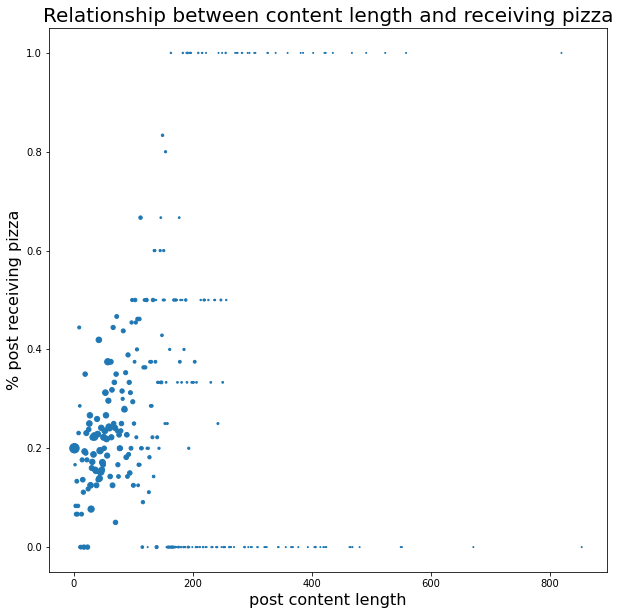

In [ ]:
def inject_content_length(df):
    clen = df['request_text_edit_aware'].str.count(' ') + 1
    df['content_length'] = clen
    return clen

warnings.filterwarnings("ignore")
inject_content_length(X_train)
inject_content_length(X_validate)
inject_content_length(X_test)
warnings.resetwarnings()

agg_data = X_train.groupby('content_length')[['requester_received_pizza','request_id']].agg({'requester_received_pizza':'mean', 'request_id':'count'})

plt.figure(figsize=(10, 10))
_ = plt.scatter(agg_data.index, agg_data.requester_received_pizza, s=agg_data.request_id)
_ = plt.xlabel('post content length', fontsize=16)
_ = plt.ylabel('% post receiving pizza', fontsize=16)
_ = plt.title("Relationship between content length and receiving pizza", fontdict={'fontsize':20})

### **Engineered Feature 2: Day of month of post (int)** <br>
We think that day of the month will have an effect in whether a request get their pizza.  We predict that people are probably more generous after they get paid, but probably less generous by the end of the month.

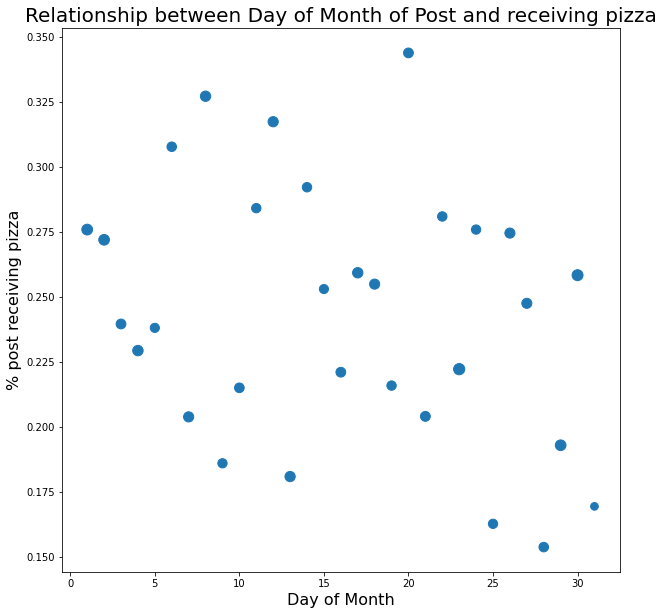

In [ ]:
def inject_day_of_month(df):
    dom = pd.to_datetime(df['unix_timestamp_of_request'], unit='s').dt.day
    df['day_of_month'] = dom
    return dom

warnings.filterwarnings("ignore")
inject_day_of_month(X_train)
inject_day_of_month(X_validate)
inject_day_of_month(X_test)
warnings.resetwarnings()

agg_data = X_train.groupby('day_of_month')[['requester_received_pizza','request_id']].agg({'requester_received_pizza':'mean', 'request_id':'count'})

plt.figure(figsize=(10, 10))
_ = plt.scatter(agg_data.index, agg_data.requester_received_pizza, s=agg_data.request_id)
_ = plt.xlabel('Day of Month', fontsize=16)
_ = plt.ylabel('% post receiving pizza', fontsize=16)
_ = plt.title("Relationship between Day of Month of Post and receiving pizza", fontdict={'fontsize':20})

### **Engineered Feature 3: Simple Topic Classification (binary)** <br>
People requesting pizza have different situations and life experiences and we would expect that the response to those stories will depend on the type of situation the poster is in.  What we would want to do is to build a labeled dataset to train a classifier in the future, but for now we build simple vocabulary-based labels to try to capture the main topic/type of each post.

In [ ]:
# Topic "key" words
family_words = ['family', 'mother', 'father', 'brother', 'sister', 'son', 'daughter', 'wife', 'husband', 'partner', 'need to feed']
job_words = ['job', 'fired', 'unemployed', 'lost job', 'laid off', 'work', 'out of work']
craving_words = ['craving', 'hungry']
money_words = ['money', 'cash', 'broke', 'destitute', 'afford', 'wallet','pay']
student_words = ['student', 'study', 'college', 'school', 'university']

def vocab_check(s, vocab):
    sl = s.lower()
    for w in vocab:
        if (w in sl):
            return 1
    else:
        return 0

# Build the topic depending on our "key" words
def adhoc_request_type_classifier(df):
    df['topic_family'] = df['request_text_edit_aware'].apply(lambda x: vocab_check(x, family_words))
    df['topic_job'] = df['request_text_edit_aware'].apply(lambda x: vocab_check(x, job_words))
    df['topic_craving'] = df['request_text_edit_aware'].apply(lambda x: vocab_check(x, craving_words))
    df['topic_money'] = df['request_text_edit_aware'].apply(lambda x: vocab_check(x, money_words))
    df['topic_student'] = df['request_text_edit_aware'].apply(lambda x: vocab_check(x, student_words))

warnings.filterwarnings("ignore")
adhoc_request_type_classifier(X_train)
adhoc_request_type_classifier(X_validate)
adhoc_request_type_classifier(X_test)
warnings.resetwarnings()

print("How often do posts with topic X get pizza?")
print()
for topic in ['topic_family', 'topic_job', 'topic_craving', 'topic_money', 'topic_student']:
  print(X_train.groupby(topic).agg({'requester_received_pizza':'mean', 'request_id':'count'}))

How often do posts with topic X get pizza?

              requester_received_pizza  request_id
topic_family                                      
0                             0.235812        2273
1                             0.273448         757
           requester_received_pizza  request_id
topic_job                                      
0                          0.224604        1959
1                          0.282913        1071
               requester_received_pizza  request_id
topic_craving                                      
0                              0.246382        2626
1                              0.237624         404
             requester_received_pizza  request_id
topic_money                                      
0                            0.208453        1396
1                            0.276622        1634
               requester_received_pizza  request_id
topic_student                                      
0                              0.241767        2

### **Engineering Text Content 1: CountVectorizer TFIDF** <br>
We will vectorize the post content and title to use in our models

In [ ]:
# Vectorize the content and the title
vectorizer_content_tfidf = TfidfVectorizer()
X_train_content_tfidf = vectorizer_content_tfidf.fit_transform(X_train['request_text_edit_aware'])
X_validate_content_tfidf = vectorizer_content_tfidf.transform(X_validate['request_text_edit_aware'])

vectorizer_title_tfidf = TfidfVectorizer()
X_train_title_tfidf = vectorizer_title_tfidf.fit_transform(X_train['request_title'])
X_validate_title_tfidf = vectorizer_title_tfidf.transform(X_validate['request_title'])

### **Engineering Text Content 2: Google's USE** <br>
We will convert the post content into fixed-length embedding vectors using Google's Universal Sentence Encoder

In [ ]:
# load embedder (Google USE)
useEmbedder = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
requestUseTrain = useEmbedder(X_train['request_text_edit_aware'])
requestUseValidate = useEmbedder(X_validate['request_text_edit_aware'])
allFeaturesTrain = np.concatenate((requestUseTrain.numpy()
                                   , X_train[numericFeatures+engineeredFeatures].to_numpy()
                                  )
                                  , axis=1)
allFeaturesValidate = np.concatenate((requestUseValidate.numpy()
                                      , X_validate[numericFeatures+engineeredFeatures].to_numpy()
                                     )
                                     , axis=1)

## **Models**

In [ ]:
# function for printing evaluations of performance (accuracy, auc, and confusion matrix)
def print_performance(trueLabels, predictedLabels):
    print('Accuracy:', accuracy_score(trueLabels, predictedLabels))
    print('\nAUC:', roc_auc_score(trueLabels, predictedLabels))
    print('\nConfusion Matrix:')
    print(pd.DataFrame(confusion_matrix(trueLabels, predictedLabels)
                       , columns=['Predicted_0', 'Predicted_1']
                       , index=['True_0', 'True_1']
                      )
         )
    
# Some lists we will need to store and compare the different models
models=list()
results=list()
accuracies=list()

### **Logistic Regression**

In [ ]:
cols_to_use = ['requester_number_of_posts_on_raop_at_request'
               ,'requester_number_of_posts_at_request'
               ,'requester_number_of_comments_in_raop_at_request'
               ,'day_of_month'
               ,'content_length'
               ,'requester_upvotes_minus_downvotes_at_request'
               ,'requester_days_since_first_post_on_raop_at_request'
               ,'giver_username_if_known']

cols_to_use = cols_to_use + interesting_subs

# Train data input
input1 = X_train[cols_to_use]
input2 = pd.DataFrame(X_train_content_tfidf.todense(), columns=vectorizer_content_tfidf.get_feature_names())
input3 = pd.DataFrame(X_train_title_tfidf.todense(), columns=vectorizer_title_tfidf.get_feature_names())

input1.reset_index(drop=True, inplace=True)
input2.reset_index(drop=True, inplace=True)
input3.reset_index(drop=True, inplace=True)

data_input = pd.concat([input1, input2, input3], axis=1)

# Test data input
input1_validate = X_validate[cols_to_use]
input2_validate = pd.DataFrame(X_validate_content_tfidf.todense(), columns=vectorizer_content_tfidf.get_feature_names())
input3_validate = pd.DataFrame(X_validate_title_tfidf.todense(), columns=vectorizer_title_tfidf.get_feature_names())

input1_validate.reset_index(drop=True, inplace=True)
input2_validate.reset_index(drop=True, inplace=True)
input3_validate.reset_index(drop=True, inplace=True)

data_input_validate = pd.concat([input1_validate, input2_validate, input3_validate], axis=1)

#### Iteration 1: Logistic Regression

In [ ]:
lr_model = LogisticRegression(multi_class='auto', tol=.015, solver="lbfgs", C=0.01, max_iter=1000, random_state=12345)
lr_model.fit(data_input, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=12345, solver='lbfgs', tol=0.015, verbose=0,
                   warm_start=False)

In [ ]:
print("TRAIN")
print_performance(y_train, lr_model.predict(data_input))
print()
print("TEST")
print_performance(y_validate, lr_model.predict(data_input_validate))

models.append("Logistic Regression - Numeric Variables + Text Embedding")
results.append(roc_auc_score(y_validate, lr_model.predict(data_input_validate)))
accuracies.append(accuracy_score(y_validate, lr_model.predict(data_input_validate)))

TRAIN
Accuracy: 0.7900990099009901

AUC: 0.5806374728481716

Confusion Matrix:
        Predicted_0  Predicted_1
True_0         2268           19
True_1          617          126

TEST
Accuracy: 0.7881188118811882

AUC: 0.5857046123805174

Confusion Matrix:
        Predicted_0  Predicted_1
True_0          750            9
True_1          205           46


It looks like a lot of the negative cases are being predicted correctly, but the positive cases aren't being predicted as accurately as much.  We may be able improve this using a higher penalty for getting the positive cases wrong.

#### Iteration 2: Penalize getting positive cases wrong more severely

In [ ]:
lr_model = LogisticRegression(multi_class='auto', tol=.015, solver="lbfgs", C=0.01, max_iter=1000, class_weight={0:1, 1:2}, random_state=12345)
lr_model.fit(data_input, y_train)

LogisticRegression(C=0.01, class_weight={0: 1, 1: 2}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=12345, solver='lbfgs', tol=0.015, verbose=0,
                   warm_start=False)

In [ ]:
print("TRAIN")
print_performance(y_train, lr_model.predict(data_input))
print()
print("TEST")
print_performance(y_validate, lr_model.predict(data_input_validate))

models.append("Logistic Regression - Penalizing Positive More")
results.append(roc_auc_score(y_validate, lr_model.predict(data_input_validate)))
accuracies.append(accuracy_score(y_validate, lr_model.predict(data_input_validate)))

TRAIN
Accuracy: 0.8168316831683168

AUC: 0.6742177831161089

Confusion Matrix:
        Predicted_0  Predicted_1
True_0         2182          105
True_1          450          293

TEST
Accuracy: 0.810891089108911

AUC: 0.683518888871392

Confusion Matrix:
        Predicted_0  Predicted_1
True_0          711           48
True_1          143          108


So, we got a better result by penalizing the getting positive cases wrong, but at the same time we got more of the negative cases wrong too.  Overall it was an improvement

### **Boosted Trees**

##### Iteration 1: Use only numeric features

In [ ]:
# choose features to use in the model
numericFeatures = ['requester_upvotes_plus_downvotes_at_request',
                   'requester_number_of_comments_at_request',
                   'requester_number_of_comments_in_raop_at_request',
                   'requester_upvotes_minus_downvotes_at_request',
                   'requester_days_since_first_post_on_raop_at_request',
                   'unix_timestamp_of_request',
                   'requester_number_of_posts_on_raop_at_request',
                   'requester_number_of_subreddits_at_request',
                   'requester_account_age_in_days_at_request',
                   'requester_number_of_posts_at_request'
                  ]
engineeredFeatures = ['content_length',
                      'day_of_month',
                      'giver_username_if_known'
                     ]
xgbTrainData = X_train[numericFeatures + engineeredFeatures]
xgbValidateData = X_validate[numericFeatures + engineeredFeatures]

In [ ]:
# run boosted trees model using xgboost
xgbObj = xgb.XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', nthread=1
                           , subsample=1.0, min_child_weight=5, max_depth=3, gamma=5, colsample_bytree=1.0 
                          , random_state=12345)
xgbObj.fit(xgbTrainData, y_train)
print("TRAIN")
print_performance(y_train, xgbObj.predict(xgbTrainData))
print("TEST")
print_performance(y_validate, xgbObj.predict(xgbValidateData))

models.append("XGB - Numeric Variables")
results.append(roc_auc_score(y_validate, xgbObj.predict(xgbValidateData)))
accuracies.append(accuracy_score(y_validate, xgbObj.predict(xgbValidateData)))

/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:242: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.
  'nthread is deprecated.', DeprecationWarning)


TRAIN
Accuracy: 0.836963696369637

AUC: 0.6716528144036074

Confusion Matrix:
        Predicted_0  Predicted_1
True_0         2278            9
True_1          485          258
TEST
Accuracy: 0.8366336633663366

AUC: 0.6779810927567728

Confusion Matrix:
        Predicted_0  Predicted_1
True_0          754            5
True_1          160           91


## **Error Analysis of XGBoost Predictions**

### Confusion Matrix

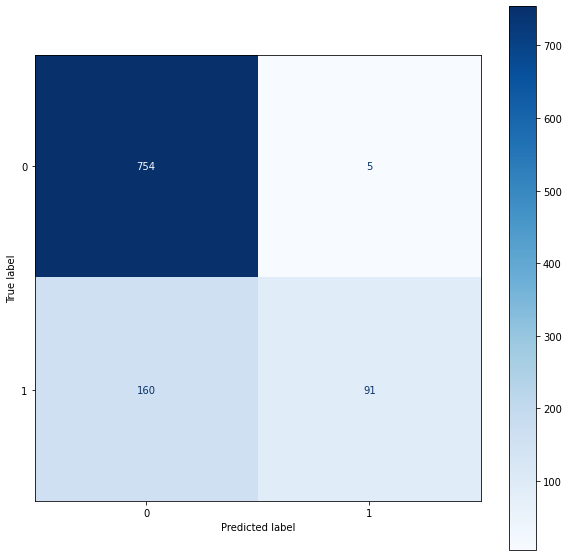

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
_ = plot_confusion_matrix(xgbObj, xgbValidateData, y_validate, cmap=plt.cm.Blues, ax=ax, values_format='d')
plt.show()

### Examples of Misclassifications

In [ ]:
# Examples of positive cases that are wrong and some that are right
X_validate_copy = X_validate.copy()
X_validate_copy['xgb_prob_getting_pizza'] = xgbObj.predict_proba(xgbValidateData)[:,1]

pd.options.display.float_format = '{:2.5f}'.format
print("Positive case, got it right:\n")
print(X_validate_copy[np.logical_and(xgbObj.predict(xgbValidateData) == 1, np.array(y_validate) == 1)][['xgb_prob_getting_pizza'] + numericFeatures + engineeredFeatures + ['request_id', 'requester_received_pizza']].transpose().iloc[:,4])
print("\nPositive case, got it wrong:\n")
print(X_validate_copy[np.logical_and(xgbObj.predict(xgbValidateData) == 0, np.array(y_validate) == 1)][['xgb_prob_getting_pizza'] + numericFeatures + engineeredFeatures + ['request_id', 'requester_received_pizza']].transpose().iloc[:,4])
pd.reset_option('^display.', silent=True)

Positive case, got it right:

xgb_prob_getting_pizza                                        0.53853
requester_upvotes_plus_downvotes_at_request                      1628
requester_number_of_comments_at_request                           368
requester_number_of_comments_in_raop_at_request                    14
requester_upvotes_minus_downvotes_at_request                      460
requester_days_since_first_post_on_raop_at_request            3.85062
unix_timestamp_of_request                            1323211893.00000
requester_number_of_posts_on_raop_at_request                        1
requester_number_of_subreddits_at_request                          46
requester_account_age_in_days_at_request                    260.64253
requester_number_of_posts_at_request                               16
content_length                                                     61
day_of_month                                                        6
giver_username_if_known                                     

#### Iteration 2: Adding text embeddings

In [ ]:
xgbObj = xgb.XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', nthread=1
                           , subsample=1.0, min_child_weight=5, max_depth=3, gamma=5, colsample_bytree=1.0 
                          , random_state=12345)
xgbObj.fit(allFeaturesTrain, y_train)

print("TRAIN")
print_performance(y_train, xgbObj.predict(allFeaturesTrain))
print("TEST")
print_performance(y_validate, xgbObj.predict(allFeaturesValidate))

models.append("XGB - Numeric Variables + Text Embedding")
results.append(roc_auc_score(y_validate, xgbObj.predict(allFeaturesValidate)))
accuracies.append(accuracy_score(y_validate, xgbObj.predict(allFeaturesValidate)))

/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:242: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.
  'nthread is deprecated.', DeprecationWarning)


TRAIN
Accuracy: 0.8900990099009901

AUC: 0.7759084791386273

Confusion Matrix:
        Predicted_0  Predicted_1
True_0         2287            0
True_1          333          410
TEST
Accuracy: 0.8346534653465346

AUC: 0.6779968400443025

Confusion Matrix:
        Predicted_0  Predicted_1
True_0          751            8
True_1          159           92


**Team Members:**

* Anthony
* Sonya
* Devin
* Michael